<a href="https://colab.research.google.com/github/Meitalg88/MyColabNotebooks/blob/main/%D7%A1%D7%95%D7%A4%D7%99_%D7%91%D7%99%D7%A0%D7%94_%D7%9E%D7%9C%D7%90%D7%9B%D7%95%D7%AA%D7%99%D7%AAipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=5164e09b7b778c120ae9d5453232d40010b766a306b031471e8a3d159e3dc8e7
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


100%|██████████| 35.5M/35.5M [00:02<00:00, 12.1MB/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 105MB/s]


Epoch 1/15, Train Loss: 0.5967, Val Loss: 0.3583, Val Accuracy: 0.8733
Epoch 2/15, Train Loss: 0.3657, Val Loss: 0.3430, Val Accuracy: 0.8863
Epoch 3/15, Train Loss: 0.3250, Val Loss: 0.2950, Val Accuracy: 0.8909
Epoch 4/15, Train Loss: 0.3428, Val Loss: 0.3321, Val Accuracy: 0.8875
Epoch 5/15, Train Loss: 0.2542, Val Loss: 0.2302, Val Accuracy: 0.9235
Epoch 6/15, Train Loss: 0.2207, Val Loss: 0.3223, Val Accuracy: 0.8867
Epoch 7/15, Train Loss: 0.1758, Val Loss: 0.2285, Val Accuracy: 0.9185
Epoch 8/15, Train Loss: 0.1857, Val Loss: 0.2981, Val Accuracy: 0.9055
Early stopping triggered after 8 epochs.


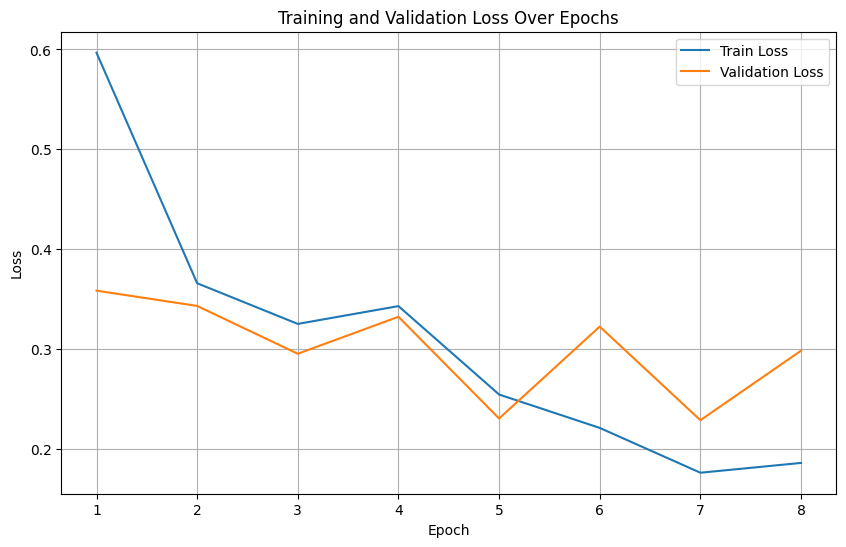


Classification Report (Detailed Metrics):
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       244
           1       0.97      0.99      0.98       624
           2       0.94      0.91      0.93       311
           3       0.71      0.95      0.81       579
           4       0.98      0.81      0.89       243
           5       0.97      0.53      0.69       284
           6       0.97      0.96      0.97       666
           7       1.00      0.99      1.00       470

    accuracy                           0.91      3421
   macro avg       0.94      0.88      0.89      3421
weighted avg       0.93      0.91      0.91      3421


Overall Metrics:
      Metric     Value
0   Accuracy  0.911429
1  Precision  0.927082
2     Recall  0.911429
3   F1 Score  0.910023


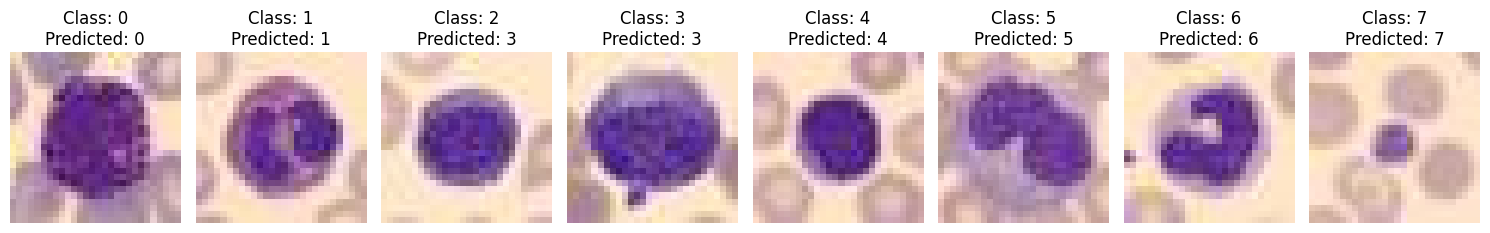

In [ ]:
!pip install torch torchvision medmnist scikit-learn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from medmnist import INFO, BloodMNIST
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# בדיקת זמינות GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. הגדרת הטרנספורמציות לנתונים
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 2. טעינת הדאטה סט והחלת הטרנספורמציה
data_train = BloodMNIST(split='train', download=True)
data_test = BloodMNIST(split='test', download=True)

train_dataset = [(transform(img), label) for img, label in zip(data_train.imgs, data_train.labels.flatten())]
test_dataset = [(transform(img), label) for img, label in zip(data_test.imgs, data_test.labels.flatten())]

# 3. פיצול הנתונים לקבוצות אימון ואימות
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 4. יצירת DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 5. הגדרת המודל
class ResNet50BloodDisease(nn.Module):
    def __init__(self, num_classes=8):
        super(ResNet50BloodDisease, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

model = ResNet50BloodDisease().to(device)

# 6. הגדרת פונקציית האובדן והאופטימייזר
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 7. לולאת אימון עם Early Stopping
def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, max_epochs=15, patience=3):
    best_val_accuracy = 0.0
    no_improvement_count = 0
    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        # שלב האימון
        model.train()
        running_train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # שלב האימות
        model.eval()
        running_val_loss = 0.0
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(targets.cpu().numpy())

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        val_accuracy = accuracy_score(val_labels, val_preds)
        print(f"Epoch {epoch + 1}/{max_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early Stopping Logic
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improvement_count = 0  # Reset counter if accuracy improves
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    return train_losses, val_losses

# 8. הפעלת האימון
train_losses, val_losses = train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, max_epochs=15, patience=3)

# 9. יצירת גרף ההפסד
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(train_losses, val_losses)

# 10. פונקציה להערכת המודל (פלט כולל תמונות)
def evaluate_model_with_images(model, test_loader, class_names):
    model.eval()
    test_preds = []
    test_labels = []
    test_images = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(targets.cpu().numpy())
            test_images.extend(inputs.cpu().numpy())

    # דוח classification report מלא
    report = classification_report(test_labels, test_preds, target_names=[class_names[c] for c in range(len(class_names))])
    print("\nClassification Report (Detailed Metrics):")
    print(report)

    # חישוב מטריקות כוללות
    overall_accuracy = accuracy_score(test_labels, test_preds)
    overall_precision = precision_score(test_labels, test_preds, average='weighted')
    overall_recall = recall_score(test_labels, test_preds, average='weighted')
    overall_f1 = f1_score(test_labels, test_preds, average='weighted')

    # טבלה של המטריקות הכלליות
    overall_metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Value': [overall_accuracy, overall_precision, overall_recall, overall_f1]
    })

    print("\nOverall Metrics:")
    print(overall_metrics_df)

    # הצגת תמונות לדוגמה
    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))
    for c, ax in enumerate(axes):
        for i, (label, pred) in enumerate(zip(test_labels, test_preds)):
            if label == c:
                img = test_images[i]
                img = img.transpose(1, 2, 0)  # שינוי למבנה התמונה
                ax.imshow((img * 0.5 + 0.5))  # ביטול נורמליזציה
                ax.set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}")
                ax.axis("off")
                break
    plt.tight_layout()
    plt.show()

    return overall_metrics_df
# 10. פונקציה להערכת המודל (פלט כולל תמונות עם מספרי Class)
def evaluate_model_with_class_numbers(model, test_loader):
    model.eval()
    test_preds = []
    test_labels = []
    test_images = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(targets.cpu().numpy())
            test_images.extend(inputs.cpu().numpy())

    # דוח classification report מלא
    report = classification_report(test_labels, test_preds)
    print("\nClassification Report (Detailed Metrics):")
    print(report)

    # חישוב מטריקות כוללות
    overall_accuracy = accuracy_score(test_labels, test_preds)
    overall_precision = precision_score(test_labels, test_preds, average='weighted')
    overall_recall = recall_score(test_labels, test_preds, average='weighted')
    overall_f1 = f1_score(test_labels, test_preds, average='weighted')

    # טבלה של המטריקות הכלליות
    overall_metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Value': [overall_accuracy, overall_precision, overall_recall, overall_f1]
    })

    print("\nOverall Metrics:")
    print(overall_metrics_df)

    # הצגת תמונות לדוגמה
    fig, axes = plt.subplots(1, len(set(test_labels)), figsize=(15, 5))
    for c, ax in enumerate(axes):
        for i, (label, pred) in enumerate(zip(test_labels, test_preds)):
            if label == c:
                img = test_images[i]
                img = img.transpose(1, 2, 0)  # שינוי למבנה התמונה
                ax.imshow((img * 0.5 + 0.5))  # ביטול נורמליזציה
                ax.set_title(f"Class: {label}\nPredicted: {pred}")
                ax.axis("off")
                break
    plt.tight_layout()
    plt.show()

    return overall_metrics_df

# הפעלה
class_names = data_train.info['label']
class_names = {int(k): v for k, v in class_names.items()}
overall_metrics_df = evaluate_model_with_class_numbers(model, test_loader)

# 12. שמירת המודל
torch.save(model.state_dict(), 'resnet50_blood_disease_model.pth')

In [ ]:
def check_dataset_sizes(train_loader, val_loader, test_loader):
    train_size = len(train_loader.dataset)
    val_size = len(val_loader.dataset)
    test_size = len(test_loader.dataset)

    print(f"Number of images in each dataset:")
    print(f"Training set: {train_size} images")
    print(f"Validation set: {val_size} images")
    print(f"Test set: {test_size} images")

# קריאה לפונקציה
check_dataset_sizes(train_loader, val_loader, test_loader)

Number of images in each dataset:
Training set: 9567 images
Validation set: 2392 images
Test set: 3421 images


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Total images in the training set: 11959
Total images in the validation set: 1712
Total images in the test set: 3421
Epoch 1/15, Train Loss: 0.5632, Val Loss: 0.4647, Val Accuracy: 0.8435
Epoch 2/15, Train Loss: 0.4306, Val Loss: 0.3391, Val Accuracy: 0.8861
Epoch 3/15, Train Loss: 0.3342, Val Loss: 0.3289, Val Accuracy: 0.8925
Epoch 4/15, Train Loss: 0.2579, Val Loss: 0.1921, Val Accuracy: 0.9305
Epoch 5/15, Train Loss: 0.2110, Val Loss: 0.1887, Val Accuracy: 0.9340
Epoch 6/15, Train Loss: 0.1835, Val Loss: 0.2859, Val Accuracy: 0.9065
Epoch 7/15, Train Loss: 0.4851, Val Loss: 0.2981, Val Accuracy: 0.9036
Epoch 8/15, Train Loss: 0.2977, Val Loss: 0.2464, Val Accuracy: 0.9136
Early stopping triggered after 8 epochs.

Classification Report:
                                                  

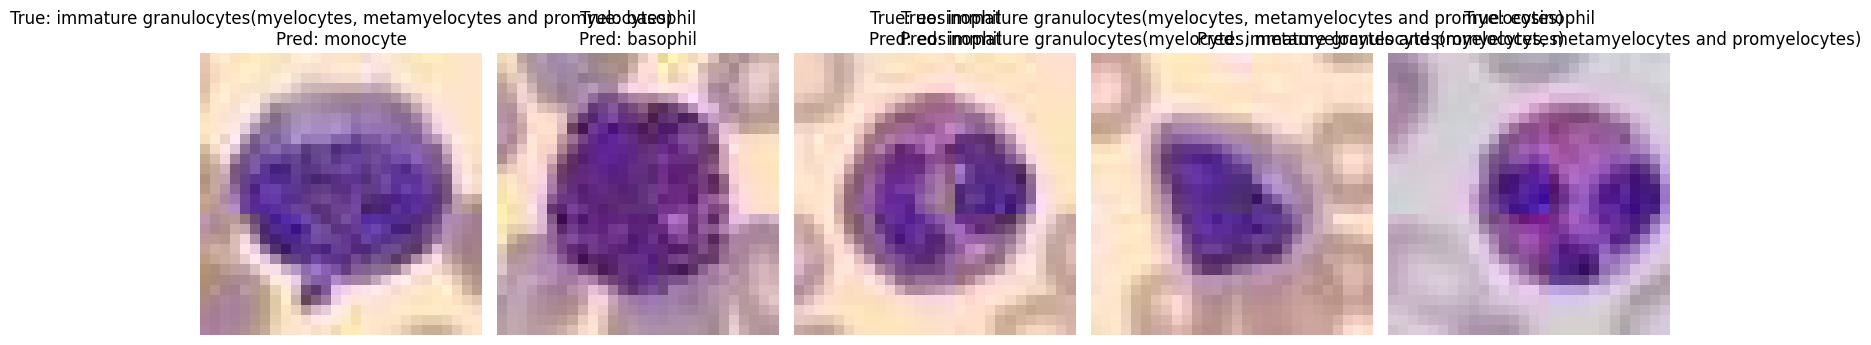

In [ ]:
# ייבוא ספריות
!pip install torch torchvision medmnist scikit-learn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from medmnist import BloodMNIST
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# בדיקת זמינות GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. הגדרת הטרנספורמציות לנתונים
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 2. טעינת כל חלקי הדאטהסט
data_train = BloodMNIST(split='train', download=True)  # 11,959 תמונות
data_val = BloodMNIST(split='val', download=True)      # 1,712 תמונות
data_test = BloodMNIST(split='test', download=True)    # 3,421 תמונות

# המרת הנתונים לפורמט מתאים
train_dataset = [(transform(img), label) for img, label in zip(data_train.imgs, data_train.labels.flatten())]
val_dataset = [(transform(img), label) for img, label in zip(data_val.imgs, data_val.labels.flatten())]
test_dataset = [(transform(img), label) for img, label in zip(data_test.imgs, data_test.labels.flatten())]

# יצירת DataLoader לכל קבוצה
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# הדפסת מספר התמונות בכל קבוצה
print(f"Total images in the training set: {len(train_dataset)}")  # צפו: 11,959
print(f"Total images in the validation set: {len(val_dataset)}")  # צפו: 1,712
print(f"Total images in the test set: {len(test_dataset)}")        # צפו: 3,421

# 3. הגדרת המודל
class ResNet50BloodDisease(nn.Module):
    def __init__(self, num_classes=8):
        super(ResNet50BloodDisease, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

model = ResNet50BloodDisease().to(device)

# 4. הגדרת פונקציית האובדן והאופטימייזר
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. לולאת אימון עם אימות בכל אפוק
def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, max_epochs=15, patience=3):
    best_val_accuracy = 0.0
    no_improvement_count = 0
    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        # שלב האימון
        model.train()
        running_train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # שלב האימות
        model.eval()
        running_val_loss = 0.0
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(targets.cpu().numpy())

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracy = accuracy_score(val_labels, val_preds)

        print(f"Epoch {epoch + 1}/{max_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early Stopping Logic
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improvement_count = 0  # Reset counter if accuracy improves
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    return train_losses, val_losses

# 6. הפעלת האימון
train_losses, val_losses = train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, max_epochs=15, patience=3)

# 7. הערכת המודל ושימוש ב-test_images
def evaluate_model_with_test_images(model, test_loader, class_names):
    model.eval()
    test_preds = []
    test_labels = []
    test_images = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(targets.cpu().numpy())
            test_images.extend(inputs.cpu().numpy())

    # דוח metrics מלא
    report = classification_report(test_labels, test_preds, target_names=[class_names[c] for c in range(len(class_names))])
    print("\nClassification Report:")
    print(report)

    # חישוב מטריקות כוללות
    overall_accuracy = accuracy_score(test_labels, test_preds)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    # הצגת תמונות לדוגמה
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # מציג 5 תמונות לדוגמה
    for i, ax in enumerate(axes):
        img = test_images[i].transpose(1, 2, 0)  # המרת טנזור לתמונה
        img = img * 0.5 + 0.5  # ביטול נורמליזציה
        ax.imshow(img)
        ax.set_title(f"True: {class_names[test_labels[i]]}\nPred: {class_names[test_preds[i]]}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    return test_images, test_labels, test_preds

# הפעלת הערכה
class_names = data_train.info['label']
class_names = {int(k): v for k, v in class_names.items()}
test_images, test_labels, test_preds = evaluate_model_with_test_images(model, test_loader, class_names)

# 8. שמירת המודל
torch.save(model.state_dict(), 'resnet50_blood_disease_model.pth')


In [ ]:
def check_dataset_sizes(train_loader, val_loader, test_loader):
    train_size = len(train_loader.dataset)
    val_size = len(val_loader.dataset)
    test_size = len(test_loader.dataset)

    print(f"Number of images in each dataset:")
    print(f"Training set: {train_size} images")
    print(f"Validation set: {val_size} images")
    print(f"Test set: {test_size} images")

# קריאה לפונקציה
check_dataset_sizes(train_loader, val_loader, test_loader)

Number of images in each dataset:
Training set: 11959 images
Validation set: 1712 images
Test set: 3421 images


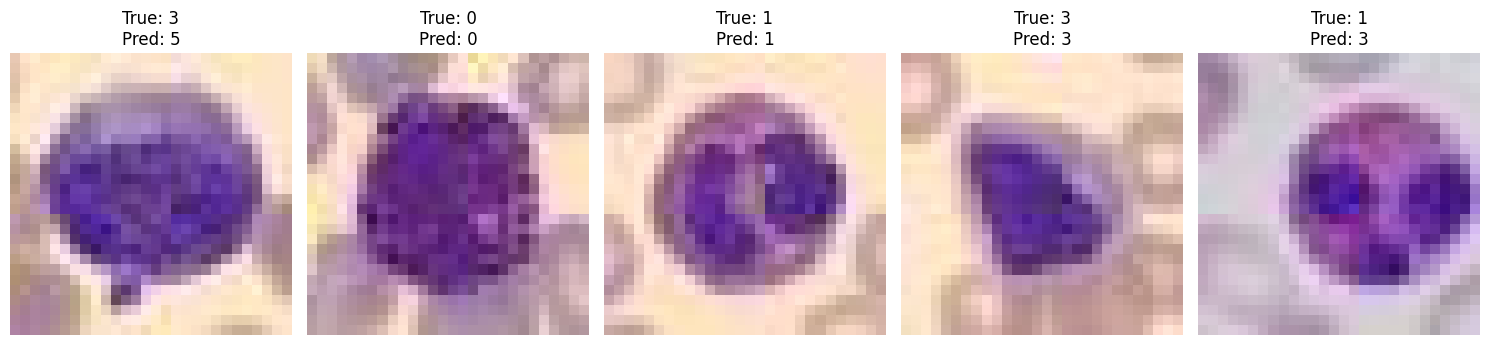

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # מציג 5 תמונות לדוגמה
for i, ax in enumerate(axes):
    img = test_images[i].transpose(1, 2, 0)  # המרת טנזור לתמונה
    img = img * 0.5 + 0.5  # ביטול נורמליזציה
    ax.imshow(img)
    ax.set_title(f"True: {test_labels[i]}\nPred: {test_preds[i]}")  # הצגת מספרי המחלקות
    ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
report = classification_report(
    test_labels,
    test_preds,
    target_names=[f"CLASS {c}" for c in range(len(class_names))]
)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     CLASS 0       0.97      0.62      0.76       244
     CLASS 1       0.98      0.97      0.98       624
     CLASS 2       0.91      0.95      0.93       311
     CLASS 3       0.69      0.93      0.79       579
     CLASS 4       0.85      0.97      0.90       243
     CLASS 5       0.93      0.69      0.79       284
     CLASS 6       0.99      0.88      0.93       666
     CLASS 7       1.00      1.00      1.00       470

    accuracy                           0.90      3421
   macro avg       0.92      0.88      0.89      3421
weighted avg       0.92      0.90      0.90      3421



In [ ]:
overall_accuracy = accuracy_score(test_labels, test_preds)
overall_precision = precision_score(test_labels, test_preds, average='weighted')
overall_recall = recall_score(test_labels, test_preds, average='weighted')
overall_f1 = f1_score(test_labels, test_preds, average='weighted')

# הצגת הפלט
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1 Score: {overall_f1:.4f}")

Overall Accuracy: 0.8992
Overall Precision: 0.9159
Overall Recall: 0.8992
Overall F1 Score: 0.8995


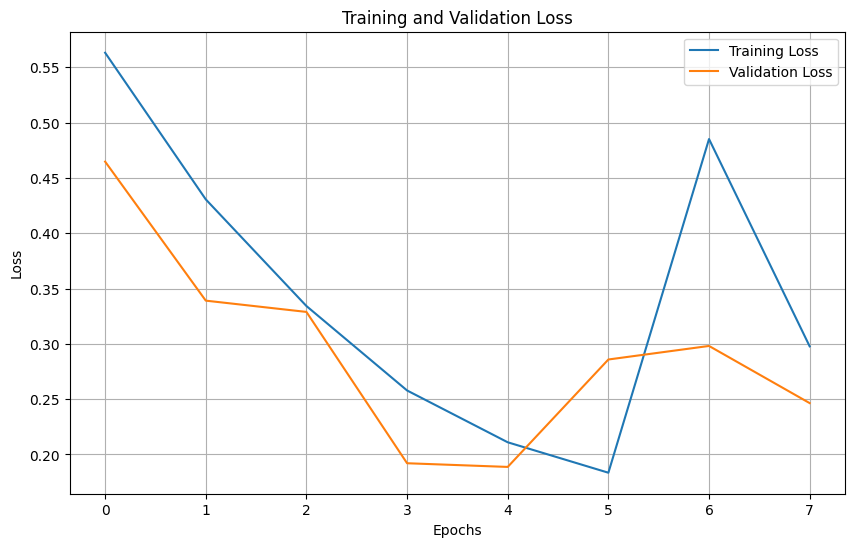

In [ ]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# קריאה לפונקציה
plot_loss(train_losses, val_losses)

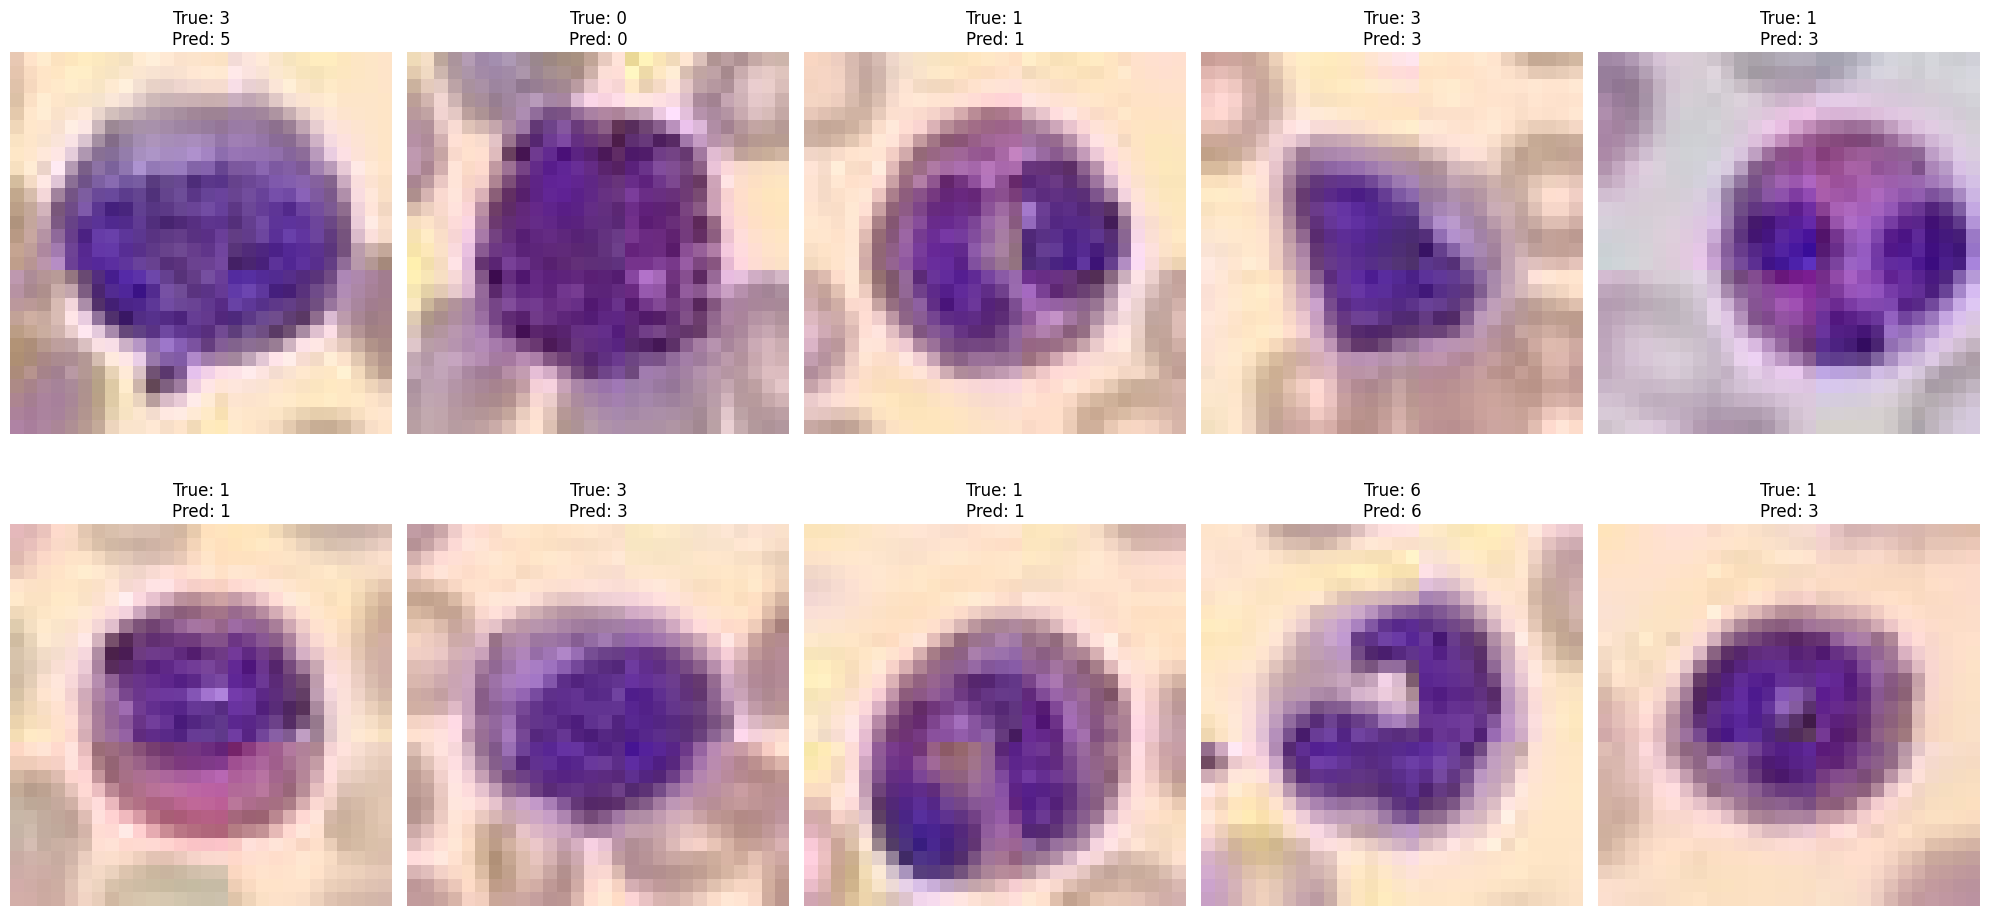

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # מציג 10 תמונות ב-2 שורות
axes = axes.flatten()  # הופך את המטריצה לרשימה שטוחה של צירים
for i, ax in enumerate(axes):
    img = test_images[i].transpose(1, 2, 0)  # המרת טנזור לתמונה
    img = img * 0.5 + 0.5  # ביטול נורמליזציה
    ax.imshow(img)
    ax.set_title(f"True: {test_labels[i]}\nPred: {test_preds[i]}")  # הצגת מספרי המחלקות
    ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
overall_accuracy = accuracy_score(test_labels, test_preds)

print(f"Test Accuracy: {overall_accuracy:.4f}")

Test Accuracy: 0.8992


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, test_preds, class_names):
    # יצירת Confusion Matrix
    cm = confusion_matrix(test_labels, test_preds)

    # הצגת Confusion Matrix עם Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# קריאה לפונקציה
plot_confusion_matrix(test_labels, test_preds, list(class_names.values()))


NameError: name 'test_labels' is not defined